#### This experiment verifies that the mono microphone is omnidirectional. 

In [3]:
import trimesh
import numpy as np
from rlr_audio_propagation import Config, Context, ChannelLayout, ChannelLayoutType
import matplotlib.pyplot as plt
import soundfile as sf

width, depth, height = 5.0, 5.0, 2.0 
vertices = np.array([
    [0, 0, 0], [width, 0, 0], [width, depth, 0], [0, depth, 0],
    [0, 0, height], [width, 0, height], [width, depth, height], [0, depth, height]
])
faces = np.array([
    [0, 1, 2], [0, 2, 3], [4, 5, 6], [4, 6, 7],
    [0, 4, 7], [0, 7, 3], [1, 5, 6], [1, 6, 2],
    [3, 2, 6], [3, 6, 7], [0, 1, 5], [0, 5, 4]
])

cfg = Config()
cfg.indirect_ray_count = 50000 
cfg.indirect_ray_depth = 25  
cfg.source_ray_count = 50000 
cfg.source_ray_depth = 25 
cfg.max_diffraction_order = 1
cfg.direct_ray_count = 8000 
cfg.max_ir_length = 1.5 
cfg.mesh_simplification = False

ctx = Context(cfg)
ctx.add_object()
ctx.set_object_position(0, [0, 0, 0])
ctx.add_mesh_vertices(vertices.flatten().tolist())
ctx.add_mesh_indices(faces.flatten().tolist(), 3, "default")
ctx.finalize_object_mesh(0)

mic_position = [width/2, depth/2, height/2]
ctx.add_listener(ChannelLayout(ChannelLayoutType.Mono, 1))
ctx.set_listener_position(0, mic_position)

max_distance = min(width, depth, height) * 0.4
source_distance = max_distance / np.sqrt(2)  
source_positions = [
    [width/2 + source_distance, depth/2, height/2],
    [width/2 - source_distance, depth/2, height/2],  
    [width/2, depth/2 + source_distance, height/2],  
    [width/2, depth/2 - source_distance, height/2],  
    [width/2, depth/2, height/2 + source_distance],  
    [width/2, depth/2, height/2 - source_distance], 
]
source_labels = ["+X", "-X", "+Y", "-Y", "+Z", "-Z"]

for i, position in enumerate(source_positions):
    ctx.add_source()
    ctx.set_source_position(i, position)

box_mesh = trimesh.Trimesh(vertices=vertices, faces=faces)
mic_mesh = trimesh.creation.icosphere(radius=0.05, subdivisions=2)
mic_mesh.apply_translation(mic_position)
mic_mesh.visual.face_colors = [255, 0, 0, 255] 

source_meshes = []
for i, position in enumerate(source_positions):
    source_sphere = trimesh.creation.icosphere(radius=0.03, subdivisions=2)
    source_sphere.apply_translation(position)
    source_sphere.visual.face_colors = [0, 255, 0, 255]  
    source_meshes.append(source_sphere)

axis = trimesh.creation.axis(origin_size=0.1, axis_length=0.5)
axis.apply_translation([0.1, 0.1, 0.1]) 

combined_mesh = trimesh.util.concatenate([box_mesh, mic_mesh, axis] + source_meshes)
print(f"Is the mesh watertight? {combined_mesh.is_watertight}")
print(f"Number of sources: {len(source_positions)}")
combined_mesh.show()

Is the mesh watertight? True
Number of sources: 6


Material for category 'default' was not found. Using default material instead.


Room Impulse Response for source 0 saved as room_impulse_response_source_0.wav
Number of IR samples: 11971
Sample rate: 44100 Hz
Room Impulse Response for source 1 saved as room_impulse_response_source_1.wav
Number of IR samples: 12049
Sample rate: 44100 Hz
Room Impulse Response for source 2 saved as room_impulse_response_source_2.wav
Number of IR samples: 12061
Sample rate: 44100 Hz
Room Impulse Response for source 3 saved as room_impulse_response_source_3.wav
Number of IR samples: 11955
Sample rate: 44100 Hz
Room Impulse Response for source 4 saved as room_impulse_response_source_4.wav
Number of IR samples: 12039
Sample rate: 44100 Hz
Room Impulse Response for source 5 saved as room_impulse_response_source_5.wav
Number of IR samples: 12041
Sample rate: 44100 Hz


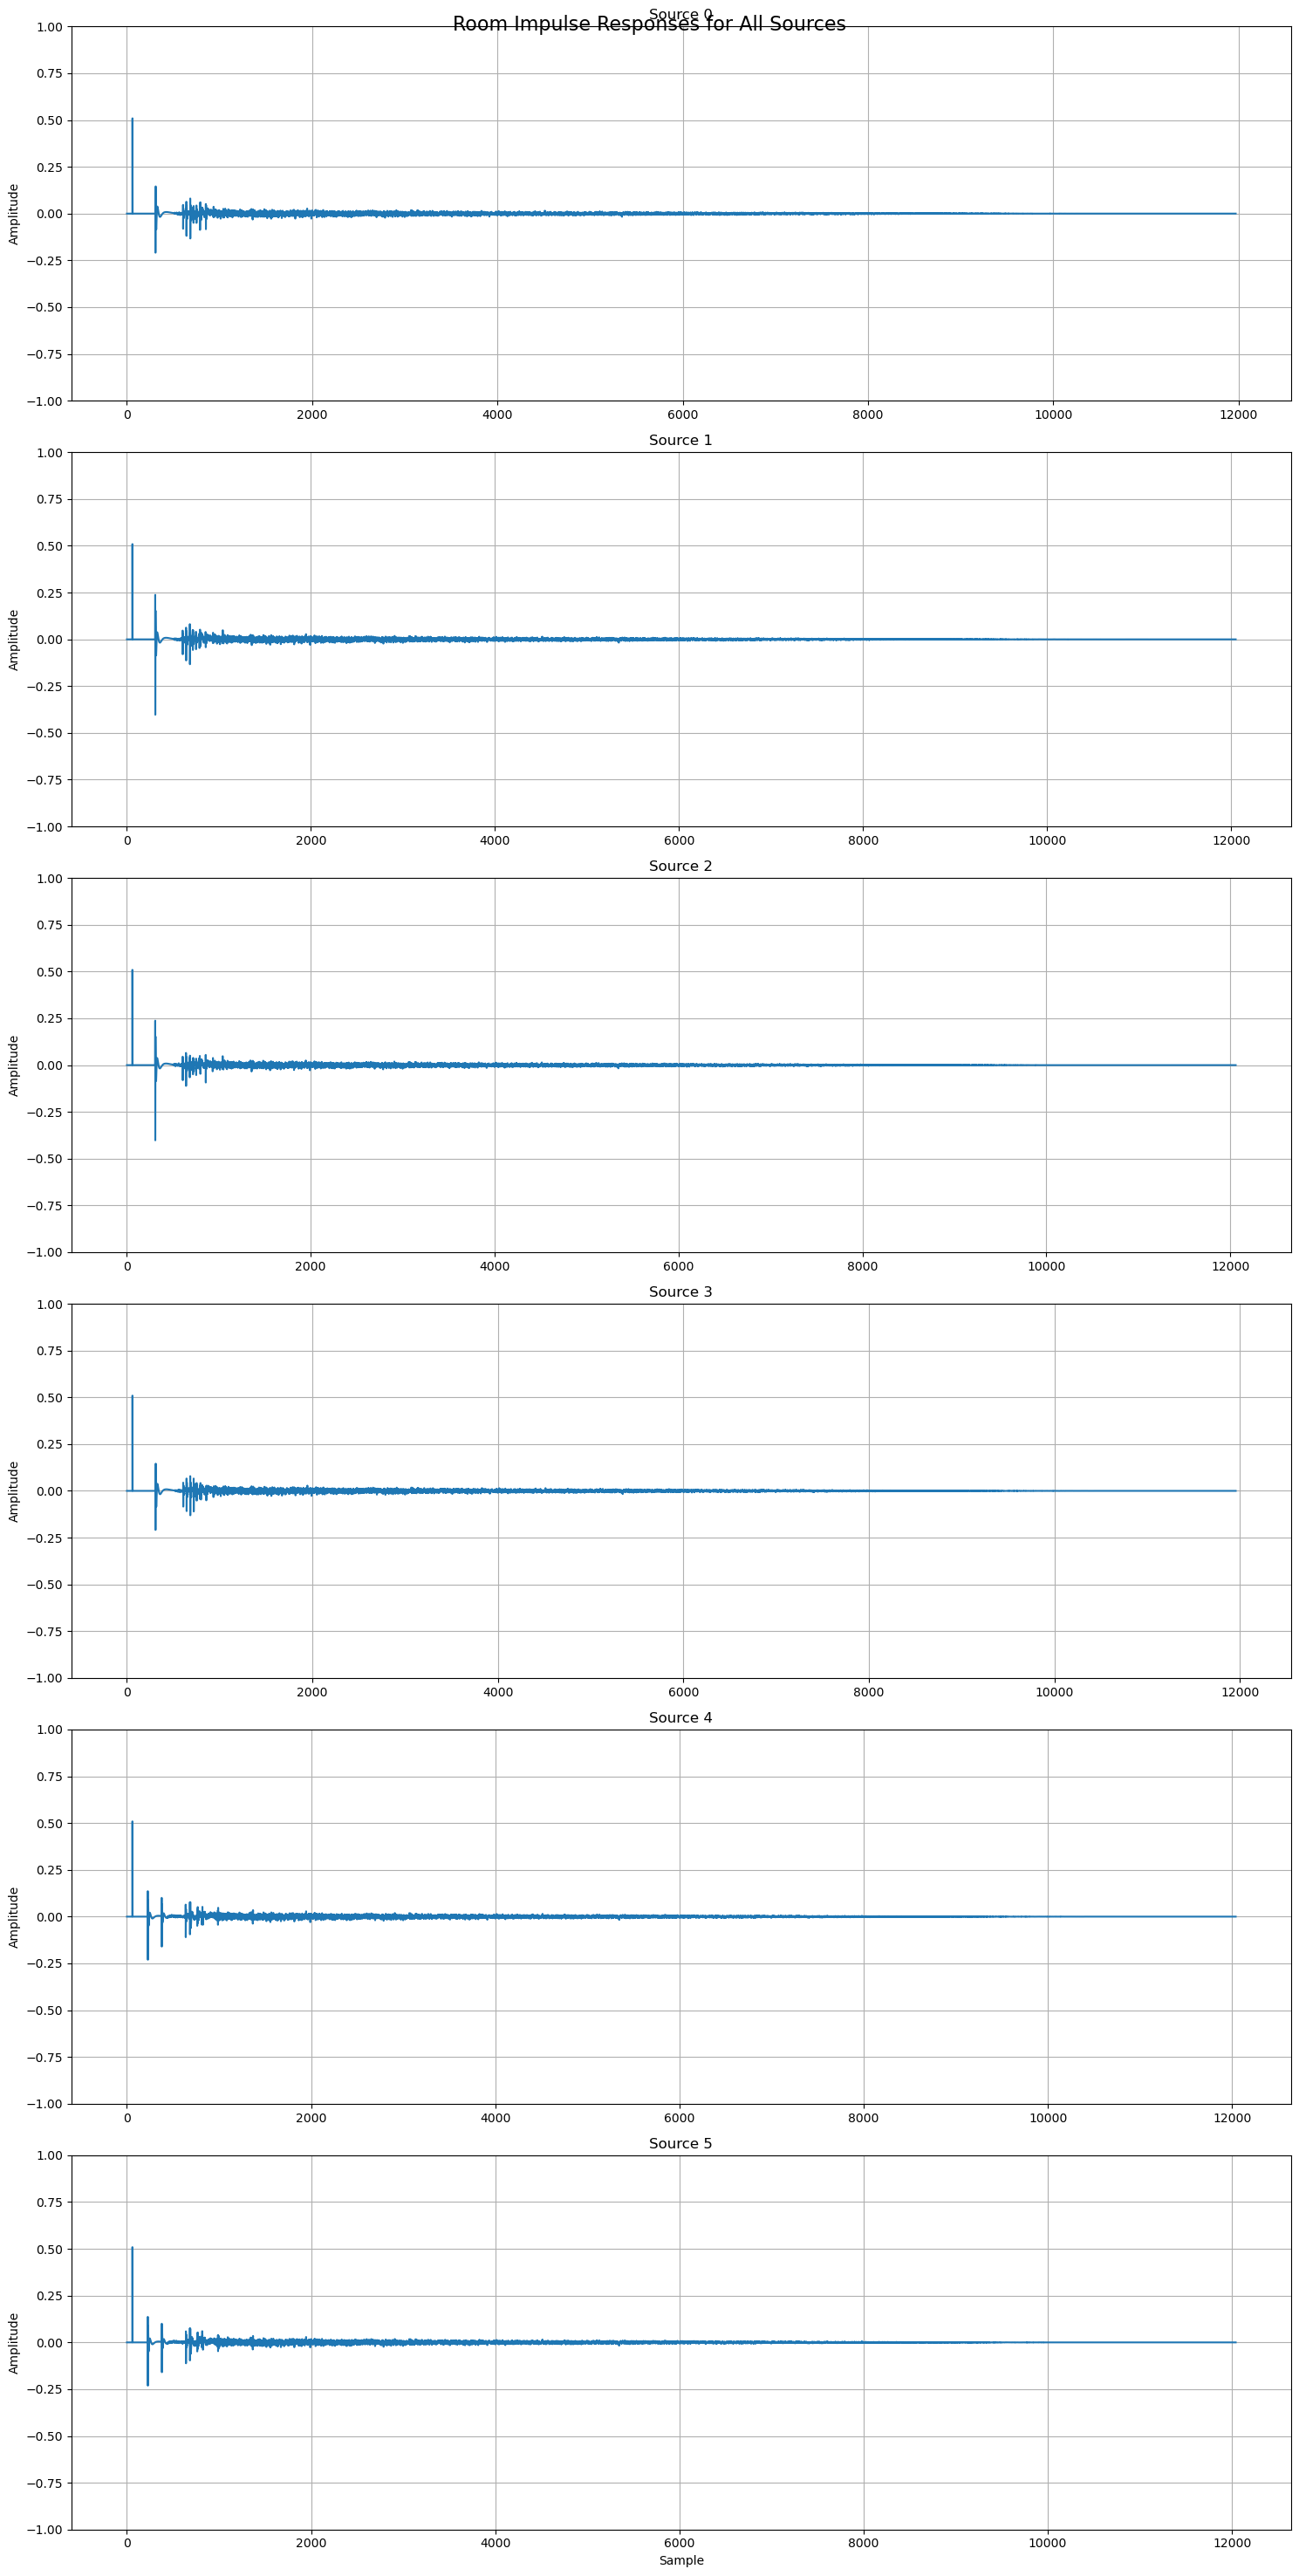

Source 0: position = [3.065685424949238, 2.5, 1.0]
Source 1: position = [1.934314575050762, 2.5, 1.0]
Source 2: position = [2.5, 3.065685424949238, 1.0]
Source 3: position = [2.5, 1.934314575050762, 1.0]
Source 4: position = [2.5, 2.5, 1.565685424949238]
Source 5: position = [2.5, 2.5, 0.434314575050762]


In [4]:
import matplotlib.pyplot as plt
import soundfile as sf
import numpy as np

ctx.simulate()

num_sources = len(source_positions)
fig, axs = plt.subplots(num_sources, 1, figsize=(15, 5*num_sources))
fig.suptitle('Room Impulse Responses for All Sources', fontsize=16)

for source_index in range(num_sources):
    output_filename = f"room_impulse_response_source_{source_index}.wav"
    listener_index = 0
    
    ir_sample_count = ctx.get_ir_sample_count(listener_index, source_index)
    ir_channel_count = ctx.get_ir_channel_count(listener_index, source_index)
    
    ir = np.array(ctx.get_ir_channel(listener_index, source_index, 0))
    
    sample_rate = int(cfg.sample_rate)
    sf.write(output_filename, ir, sample_rate)
    
    print(f"Room Impulse Response for source {source_index} saved as {output_filename}")
    print(f"Number of IR samples: {ir_sample_count}")
    print(f"Sample rate: {sample_rate} Hz")
    
    ax = axs[source_index] if num_sources > 1 else axs
    ax.plot(ir)
    ax.set_title(f'Source {source_index}')
    ax.set_ylim([-1, 1])
    ax.set_ylabel('Amplitude')
    ax.grid(True)
    
    if source_index == num_sources - 1:
        ax.set_xlabel('Sample')

plt.tight_layout()
plt.show()

# Print source positions for reference
for i, pos in enumerate(source_positions):
    print(f"Source {i}: position = {pos}")